In [1]:
!pip install SpeechRecognition
!pip install text2emotion
!pip install textblob
!python -m textblob.download_corpora
!pip install pyldavis
!pip install pandas
!pip install reportlab
!pip install pydub

Finished.


[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\victo\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\victo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\victo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\victo\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to
[nltk_data]     C:\Users\victo\AppData\Roaming\nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\victo\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!

In [2]:
import csv
from os.path import exists, getsize
from os import fsdecode, listdir
import io
import pandas as pd
from gensim import corpora, models
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
import numpy as np
import matplotlib.pyplot as plt
import nltk
import text2emotion as te
import speech_recognition as sr
from textblob import TextBlob
import pyLDAvis.gensim_models
from pydub import AudioSegment
import math
from reportlab.platypus import SimpleDocTemplate, Paragraph, Image, PageBreak
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.lib.units import inch
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\victo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\victo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\victo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
C:\Users\victo\AppData\Local\Programs\Python\Python39\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [3]:
r = sr.Recognizer()
np.random.seed(2018)
nltk.download('wordnet')
stemmer = SnowballStemmer('english')

def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text):
    result = []
    for token in simple_preprocess(text):
        if token not in STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

directory = './'
path = './initialData'
csvPath = directory + 'fileData.csv'

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\victo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
# This class is what breaks .wav files into smaller segments 
class SplitWavAudioMubin():
    def __init__(self, folder, filename):
        self.folder = folder
        self.filename = filename
        self.filepath = folder + '\\' + filename
        
        self.audio = AudioSegment.from_wav(self.filepath)
    
    def get_duration(self):
        return self.audio.duration_seconds
    
    def single_split(self, from_min, to_min, split_filename):
        t1 = from_min * 120 * 1000
        t2 = to_min * 120 * 1000
        split_audio = self.audio[t1:t2]
        split_audio.export(self.folder + '\\' + split_filename, format="wav")
        
    def multiple_split(self, min_per_split):
        splitDict = []
        total_mins = math.ceil(self.get_duration() / 120)
        for i in range(0, total_mins, min_per_split):
            fileBreak = self.filename.split('.')
            name = fileBreak[0]
            ext = fileBreak[1]
            split_fn = name + '' + str(i) + '.' + ext
            self.single_split(i, i+min_per_split, split_fn)
            print(str(i) + ' Done')
            splitDict.append(split_fn)
            if i == total_mins - min_per_split:
                print(self.filename + ' All split successfully')
        return splitDict

def checkLength(file):
        audio = AudioSegment.from_wav(path + '/' + file)
        duration = audio.duration_seconds
        return duration

def buildDataSet():
    # Filter out the .wav audio files under the dir
    dataset = []
    for files in listdir(path):
        if files.endswith('.wav'):
            # checks to make sure the length of the file is less than 2 minutes
            if(checkLength(files) <= 120):
                dataset.append(files)
            else:
                split_wav = SplitWavAudioMubin(path, files)
                # make a dictionary in multiple split then loop through that to add to dataset[]
                for files in split_wav.multiple_split(min_per_split=1):
                    dataset.append(files)
        elif files.endswith('.txt'):
            dataset.append(files)
    return dataset

def recognizeWav(file):
    # create a variable that will become the source (Make sure to have the path)
    temp = sr.AudioFile(path + '/' + file)
    with temp as source:
        audio=r.record(source)
    try:
        # Limitations: https://cloud.google.com/speech-to-text/quotas
        val = r.recognize_google(audio)
        # Add the newly created .wav to text variable to a document
        return val
    except:
        # If an error occurs with reading the file
        return "..."

dataset = buildDataSet()

In [7]:
# if you want to reprocess files already in an existing fileData.csv file in this directory, comment out the below 5 lines of code
recordedCSVFiles = []
if exists(csvPath) and getsize(csvPath) > 0:
      fileData = pd.read_csv(csvPath, encoding= 'unicode_escape')
      fileNames = fileData[['fileName']].copy(deep=True)
      recordedCSVFiles = fileNames

csvOutput = open(csvPath, 'a', encoding='utf-8')
writer = csv.DictWriter(csvOutput, fieldnames=['fileIndex', 'fileName', 'originalFileType', 'fileContents', 'emotionComposition', 'polarity'])
writer.writeheader()

fileCount = 0
textFiles = 0
audioFiles = 0
wordCount = 0
fileSize = 0
textFileSize = 0
audioFileSize = 0

for file in sorted(listdir(directory + 'initialData/')):
  if (fileCount % 100 == 0 and fileCount != 0): 
    print('Finished writing files: ' + str(fileCount))
  filename = fsdecode(file)

  fileNameWOType = filename.split('.')[0]
  fileType = filename.split('.')[1]

# if you want to reprocess files already in an existing fileData.csv file in this directory, comment out the below 3 lines of code
  if len(recordedCSVFiles) != 0 and recordedCSVFiles['fileName'].str.contains(fileNameWOType).sum() > 0:
        print('Skipping over ' + fileNameWOType)
        continue

  if filename.endswith('.wav'):
    fileCount = fileCount + 1
    audioFiles = audioFiles + 1
    filecontents = recognizeWav(filename)
    audioFileSize = audioFileSize + getsize(path + '/' + filename)
  elif filename.endswith('.txt'):
    fileCount = fileCount + 1
    textFiles = textFiles + 1
    textFileSize = textFileSize + getsize(path + '/' + filename)
    readFile = io.open(path + '/' + filename, 'r', encoding='utf-8')
    filecontents = readFile.read()
    readFile.close()

# add the file details, emotion analysis, and polarity to the CSV
  emotionSet = te.get_emotion(filecontents)
  sentimentAnalysis = TextBlob(filecontents).sentiment
  wordCount = wordCount + len(filecontents.split())
  fileSize = fileSize + getsize(path + '/' + filename)
  writer.writerow({'fileName': str(fileNameWOType), 'originalFileType': fileType, 
                   'fileContents': filecontents, 'fileIndex':fileCount, 
                   'emotionComposition': emotionSet, 'polarity': sentimentAnalysis.polarity})

csvOutput.close()

If any error was experienced during the CSV generation process, you can recalculate the variables for the directory contents in the code block below:

In [8]:
fileCount = 0
textFiles = 0
audioFiles = 0
wordCount = 0
fileSize = 0
textFileSize = 0
audioFileSize = 0

for file in sorted(listdir(directory + 'initialData/')):
  filename = fsdecode(file)

  if filename.endswith('.wav') and checkLength(file) <= 120: # only append data for audio files below 2 minutes in length, due to API restrictions
                                                             # this will cause the data to be slightly inaccurate, since a longer file will be represented by a larger number of files than 1
    fileCount = fileCount + 1
    audioFileSize = audioFileSize + getsize(path + '/' + filename)
    fileSize = fileSize + getsize(path + '/' + filename)
    audioFiles = audioFiles + 1
  elif filename.endswith('.txt'):
    fileCount = fileCount + 1
    textFiles = textFiles + 1
    textFileSize = textFileSize + getsize(path + '/' + filename)
    fileSize = fileSize + getsize(path + '/' + filename)

In [9]:
# store the file contents of the data set, and create a processed version omitting stopwords and lemmatizing the words within
concatenatedData = pd.read_csv(csvPath)
data_contents = concatenatedData[['fileContents']].copy(deep=True)
data_contents['index'] = concatenatedData[['fileIndex']]
documents = data_contents

processedDocuments = documents['fileContents'].map(preprocess)
polaritySeries = concatenatedData[['polarity']].squeeze()
averagePolarity = polaritySeries.mean()
dictionary = corpora.Dictionary(processedDocuments)
bow_corpus = [dictionary.doc2bow(doc) for doc in processedDocuments]

for fileString in data_contents['fileContents']:
  wordCount = wordCount + len(fileString)

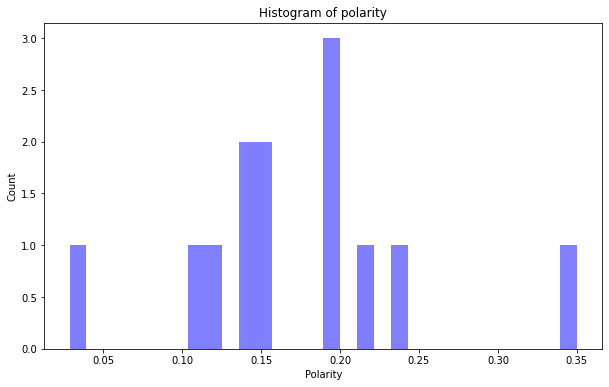

In [10]:
# identify the words in order of frequency within both the processed and unprocessed data stores
unprocessedTenFrequentWords = pd.Series(' '.join(documents.fileContents).split()).value_counts()[:10]
processedFrequentWords = pd.value_counts(processedDocuments.apply(pd.Series).stack())
processedTenFrequentWords = processedFrequentWords[:10]

# create a histogram of the polarities in the dataset by file count
plt.figure(figsize=(10,6))
n, bins, patches = plt.hist(polaritySeries, 30, facecolor='blue', alpha=0.5)
plt.xlabel('Polarity')
plt.ylabel('Count')
plt.title('Histogram of polarity')
plt.savefig('polarityHistogram.png')

# create a word cloud of the most frequently occuring words
wordcloud = WordCloud(width=1000, height=600).generate_from_frequencies(processedFrequentWords)
wordcloud.to_file('Wordcloud.png')

In [11]:
# using Latent Dirichlet Allocation, derive the most common topics, their word makeup, and their distribution
lda = models.ldamodel.LdaModel(corpus=bow_corpus, id2word=dictionary, num_topics=6, iterations=200)

for idx, topic in lda.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx + 1, topic))

plot = pyLDAvis.gensim_models.prepare(lda,bow_corpus,dictionary)
pyLDAvis.save_html(plot, 'TopicBreakdown.html')

Topic: 1 
Words: 0.014*"think" + 0.010*"design" + 0.009*"like" + 0.009*"year" + 0.007*"laughter" + 0.007*"go" + 0.007*"want" + 0.007*"religion" + 0.007*"book" + 0.006*"peopl"
Topic: 2 
Words: 0.012*"world" + 0.012*"design" + 0.010*"peopl" + 0.009*"go" + 0.008*"think" + 0.008*"know" + 0.007*"smallpox" + 0.007*"year" + 0.007*"want" + 0.007*"like"
Topic: 3 
Words: 0.012*"like" + 0.009*"go" + 0.007*"music" + 0.006*"applaus" + 0.005*"laughter" + 0.005*"play" + 0.005*"draw" + 0.005*"laptop" + 0.005*"thing" + 0.004*"kind"
Topic: 4 
Words: 0.016*"peopl" + 0.015*"thing" + 0.013*"think" + 0.013*"know" + 0.012*"like" + 0.012*"go" + 0.010*"world" + 0.009*"year" + 0.008*"come" + 0.008*"look"
Topic: 5 
Words: 0.012*"know" + 0.011*"year" + 0.011*"world" + 0.010*"like" + 0.009*"go" + 0.009*"want" + 0.008*"peopl" + 0.008*"design" + 0.007*"laughter" + 0.007*"work"
Topic: 6 
Words: 0.006*"thing" + 0.005*"like" + 0.004*"kind" + 0.003*"think" + 0.003*"know" + 0.003*"go" + 0.003*"year" + 0.003*"laughter" + 

C:\Users\victo\AppData\Local\Programs\Python\Python39\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


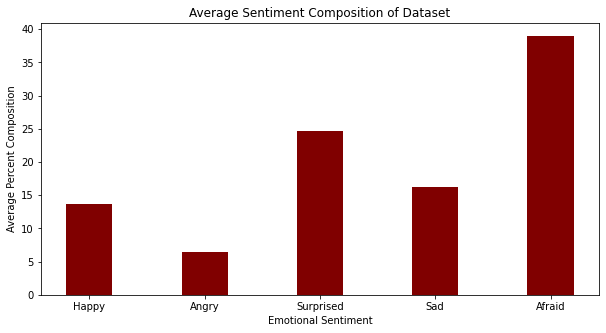

In [12]:
emotionCompositions = concatenatedData[['emotionComposition']].copy(deep=True)

happy = 0
angry = 0
sad = 0
surprised = 0
fear = 0
for emotionObjString in emotionCompositions['emotionComposition']:
  emotionDict = eval(str(emotionObjString))
  global happy, angry, sad, surprised, fear
  happy += emotionDict['Happy']
  angry += emotionDict['Angry']
  surprised += emotionDict['Surprise']
  sad += emotionDict['Sad']
  fear += emotionDict['Fear']

emotionSum = happy + angry + surprised + sad + fear
emotionAverage = emotionSum / documents.size
emotionData = {'Happy': happy / documents.size / emotionAverage * 100, 'Angry': angry / documents.size / emotionAverage * 100,
               'Surprised': surprised / documents.size / emotionAverage * 100, 'Sad': sad / documents.size / emotionAverage * 100,
               'Afraid': fear / documents.size / emotionAverage * 100}

fig = plt.figure(figsize = (10, 5))
plt.bar(emotionData.keys(), emotionData.values(), color ='maroon', width = 0.4)

# create and save a histogram of emotional composition as averages over the dataset
plt.xlabel("Emotional Sentiment")
plt.ylabel("Average Percent Composition")
plt.title("Average Sentiment Composition of Dataset")
plt.savefig('emotionComposition.png')

The following two sections set up and create a PDF document as output for the model's analysis.

In [13]:
styles = getSampleStyleSheet()
pdfOutput = SimpleDocTemplate("DataMiningReport.pdf")
pdfComponents = []

styles = getSampleStyleSheet()
title_style = styles['Heading1']
title_style.alignment = 1
title = Paragraph("Bimodal Data Mining Report", title_style)

lineBreak = "<br/><br/>"

fileCount1 = "<font size = '12'><strong>Number of files analyzed:</strong> " + str(fileCount) + "</font>"
fileCount2 = "<font size = '12'><strong>Number of text files analyzed:</strong> " + str(textFiles) + "</font>"
fileCount3 = "<font size = '12'><strong>Number of audio files analyzed:</strong> " + str(audioFiles) + "</font>"

fileSize1 = "<font size = '12'><strong>Total file size analyzed:</strong> " + str(fileSize) + " bytes (" + str(round(fileSize / 1000000000, 2)) + " GB).</font>"
fileSize2 = "<font size = '12'><strong>Total text file size analyzed:</strong> "  + str(textFileSize) + " bytes (" + str(round(textFileSize / 1000000000, 2)) + " GB).</font>"
fileSize3 = "<font size = '12'><strong>Total audio file size analyzed:</strong> " + str(audioFileSize) + " bytes (" + str(round(audioFileSize / 1000000000, 2)) + " GB).</font>"

wordAnalysis1 = "<font size = '12'><strong>Total data word count:</strong> " + str(wordCount) + "</font>"
wordAnalysis2 = "<font size = '12'><strong>Most common words:</strong></font>"

polarity1 = "<font size = '12'><strong>Average dataset polarity:</strong> " + str(round(averagePolarity, 3)) + "</font>"
polarity2 = "<font size = '12'>Polarity is a representation of whether the emotion of the data is overall generally positive or negative, with -1 being a completely negative score, and positive 1 being completely positive.</font>"
polarity3 = "<font size = '12'><strong>Number of files per polarity subset:</strong></font>"

topicMining1 = "<font size = '12'><strong>Topic Breakdown</strong></font>"
topicMining2 = "<font size = '12'>These wordsets represent the topics most representative of the entire dataset, based on their frequency of appearance. The words in each topic are shown with their relative weight of importance.</font>"
topicMining3 = "<font size = '12'>For a clearer, interactive view of these topics and their compositions, open the file 'TopicBreakdown.html' in a browser.</font>"

emotionalComposition1 = "<font size = '12'><strong>Average Emotional Distribution:</strong></font>"

wordcloudImage = Image('./Wordcloud.png', 5*inch, 3*inch)
polarityImage = Image('./polarityHistogram.png', 5*inch, 3*inch)
emotionImage = Image('./emotionComposition.png', 5*inch, 3*inch)

In [14]:
pdfComponents.append(title)
pdfComponents.append(Paragraph(lineBreak))

pdfComponents.append(Paragraph(fileCount1))
pdfComponents.append(Paragraph(fileCount2))
pdfComponents.append(Paragraph(fileCount3))
pdfComponents.append(Paragraph(lineBreak))

pdfComponents.append(Paragraph(fileSize1))
pdfComponents.append(Paragraph(fileSize2))
pdfComponents.append(Paragraph(fileSize3))
pdfComponents.append(Paragraph(lineBreak))

pdfComponents.append(Paragraph(wordAnalysis1))
pdfComponents.append(Paragraph(wordAnalysis2))
for (index, value) in processedTenFrequentWords.items():
    pdfComponents.append(Paragraph("<font size = '12'><strong>" + str(index) + "</strong> (" + str(value) + ")</font>"))
pdfComponents.append(Paragraph(lineBreak))

pdfComponents.append(wordcloudImage)
pdfComponents.append(PageBreak())

pdfComponents.append(Paragraph(polarity1))
pdfComponents.append(Paragraph(polarity2))
pdfComponents.append(Paragraph(lineBreak))
pdfComponents.append(Paragraph(polarity3))
pdfComponents.append(Paragraph(lineBreak))
pdfComponents.append(polarityImage)
pdfComponents.append(Paragraph(lineBreak))

pdfComponents.append(Paragraph(topicMining1))
pdfComponents.append(Paragraph(topicMining2))
for idx, topic in lda.print_topics(-1):
    pdfComponents.append(Paragraph("<font size = '12'><strong>Topic " + str(idx + 1) + ": </strong></font>"))
    pdfComponents.append(Paragraph("<font size = '12'>" + topic + "</font>"))
pdfComponents.append(PageBreak())

pdfComponents.append(Paragraph(emotionalComposition1))
pdfComponents.append(emotionImage)

pdfOutput.build(pdfComponents)